# PUI Homework 11: Time Series Clustering

In [1]:
__author__ = 'Ruben Hambardzumyan (rh2684), based on a skeleton notebook instructions created by Dr. Federica Bianco'

## 1. Template Set up

In [221]:
from __future__ import print_function

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import geopandas as gpd

import zipfile
import os
import sys
import urllib as url

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.mixture import GaussianMixture

import shapefile as shp
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch

% matplotlib inline

# Checking the $PUIDATA environmental variable

if not os.environ.get('PUIDATA'):
    print('The $PUIDATA environmental variable does not exist!')

# Setting the significance level

alpha = 0.05

# Setting the random seed

np.random.seed(1452)

## 2. Data

In [3]:
!mkdir $PUIDATA/archives

In [5]:
# Getting the Census data

!for ((y=94; y<=99; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; mv zbp$y\totals.zip $PUIDATA/archives; done

!for ((y=0; y<=1; y+=1)); do wget \
https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; mv zbp0$y\totals.zip $PUIDATA/archives; done

!for ((y=2; y<=9; y+=1)); do wget \
https://www2.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; mv zbp0$y\totals.zip $PUIDATA/archives; done

!for ((y=10; y<=14; y+=1)); do wget \
https://www2.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; mv zbp$y\totals.zip $PUIDATA/archives; done

--2017-12-14 15:48:59--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611524 (597K) [application/zip]
Saving to: “zbp94totals.zip”

100%[======================================>] 611,524     --.-K/s   in 0.09s   

2017-12-14 15:48:59 (6.14 MB/s) - “zbp94totals.zip” saved [611524/611524]

mv: setting attribute `security.selinux' for `security.selinux': Permission denied
--2017-12-14 15:48:59--  https://www2.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp95totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:295::208c, 2600:141b:13:288::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625328 (611K) [application/zip]
Saving to: “zbp95totals.zip”

100%[==================

Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 663242 (648K) [application/zip]
Saving to: “zbp08totals.zip.4”

100%[======================================>] 663,242     --.-K/s   in 0.06s   

2017-12-14 15:49:02 (10.1 MB/s) - “zbp08totals.zip.4” saved [663242/663242]

mv: setting attribute `security.selinux' for `security.selinux': Permission denied
--2017-12-14 15:49:02--  https://www2.census.gov/econ2009/CBP_CSV/zbp09totals.zip
Resolving www2.census.gov... 104.106.248.146, 2600:141b:13:288::208c, 2600:141b:13:295::208c
Connecting to www2.census.gov|104.106.248.146|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 660109 (645K) [application/zip]
Saving to: “zbp09totals.zip.4”

100%[======================================>] 660,109     --.-K/s   in 0.02s   

2017-12-14 15:49:02 (26.7 MB/s) - “zbp09to

In [9]:
url.urlretrieve('https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip', 'zipcode.zip')
os.system('mv zipcode.zip $PUIDATA')
os.system('unzip -o $PUIDATA/zipcode.zip -d $PUIDATA/zipcodes')

0

In [10]:
zipShp = gpd.read_file(os.environ.get('PUIDATA') + '/zipcodes/ZIP_CODE_040114.shp')

In [11]:
zipShp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [12]:
zipShp.shape

(263, 13)

In [13]:
!ls $PUIDATA/archives

zbp00totals.zip  zbp06totals.zip  zbp12totals.zip  zbp97totals.zip
zbp01totals.zip  zbp07totals.zip  zbp13totals.zip  zbp98totals.zip
zbp02totals.zip  zbp08totals.zip  zbp14totals.zip  zbp99totals.zip
zbp03totals.zip  zbp09totals.zip  zbp94totals.zip
zbp04totals.zip  zbp10totals.zip  zbp95totals.zip
zbp05totals.zip  zbp11totals.zip  zbp96totals.zip


In [18]:
# Creating the list of files in the folder

files = os.listdir(os.getenv('PUIDATA') + '/archives')

In [21]:
files.remove('.ipynb_checkpoints')

In [73]:
PUIdata = os.environ.get('PUIDATA')
dfList = pd.DataFrame()
date = 1994

for i in range(21):
    fname=files[i]
    zf = zipfile.ZipFile(PUIdata + '/archives/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt'))).assign(year=date)
    df.columns = [j.upper() for j in df.columns]
    df = df[['ZIP', 'EST', 'YEAR']]
    dfList = dfList.append(df)
    date += 1

In [74]:
dfList = dfList.rename(columns={'ZIP':'ZIPCODE', 'EST':'EST', 'YEAR':'YEAR'})

In [75]:
dfList.head()

,ZIPCODE,EST,YEAR
0,1001,439,1994
1,1002,450,1994
2,1003,10,1994
3,1004,47,1994
4,1005,92,1994


In [76]:
merged = pd.merge(zipShp, dfList, left_index=True, right_index=True, on='ZIPCODE', how = 'inner')

In [77]:
merged.shape

(5523, 15)

In [78]:
merged = merged.dropna(axis=0, how='any');

In [79]:
merged.shape

(5523, 15)

In [81]:
columnList = merged.YEAR.unique()

In [82]:
columnList

array([1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [147]:
finalDf = pd.DataFrame(columns = ['ZIPCODE', columnList[0], columnList[1], columnList[2], columnList[3],
                               columnList[4], columnList[5], columnList[6], columnList[7],
                               columnList[8], columnList[9], columnList[10], columnList[11],
                               columnList[12], columnList[13], columnList[14], columnList[15],
                               columnList[16], columnList[17], columnList[18], columnList[19],
                               columnList[20]])

In [149]:
finalDf.ZIPCODE = merged.ZIPCODE

In [158]:
# Sorry for not pythonic solution, but no time to make a nice loop for this

finalDf[1994].iloc[0:] = merged.EST.iloc[0::21]
finalDf[1995].iloc[0:] = merged.EST.iloc[1::21]
finalDf[1996].iloc[0:] = merged.EST.iloc[2::21]
finalDf[1997].iloc[0:] = merged.EST.iloc[3::21]
finalDf[1998].iloc[0:] = merged.EST.iloc[4::21]
finalDf[1999].iloc[0:] = merged.EST.iloc[5::21]
finalDf[2000].iloc[0:] = merged.EST.iloc[6::21]
finalDf[2001].iloc[0:] = merged.EST.iloc[7::21]
finalDf[2002].iloc[0:] = merged.EST.iloc[8::21]
finalDf[2003].iloc[0:] = merged.EST.iloc[9::21]
finalDf[2004].iloc[0:] = merged.EST.iloc[10::21]
finalDf[2005].iloc[0:] = merged.EST.iloc[11::21]
finalDf[2006].iloc[0:] = merged.EST.iloc[12::21]
finalDf[2007].iloc[0:] = merged.EST.iloc[13::21]
finalDf[2008].iloc[0:] = merged.EST.iloc[14::21]
finalDf[2009].iloc[0:] = merged.EST.iloc[15::21]
finalDf[2010].iloc[0:] = merged.EST.iloc[16::21]
finalDf[2011].iloc[0:] = merged.EST.iloc[17::21]
finalDf[2012].iloc[0:] = merged.EST.iloc[18::21]
finalDf[2013].iloc[0:] = merged.EST.iloc[19::21]
finalDf[2014].iloc[0:] = merged.EST.iloc[20::21]

In [159]:
finalDf = finalDf.drop_duplicates(['ZIPCODE'], keep='first');

In [161]:
finalDf.head()

,ZIPCODE,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,11436,439,2,4,4,3,2,1,6,11,...,2,8,5,3,2,2,2,2,2,4
1,11213,450,4,11,8,444,469,493,490,490,...,509,509,503,477,458,448,436,453,439,458
2,11212,10,439,433,457,490,558,563,587,566,...,589,582,596,584,571,570,558,572,572,560
3,11225,47,467,487,500,14,13,13,13,15,...,12,12,16,17,16,16,16,15,15,18
4,11218,92,10,13,15,31,35,48,37,23,...,31,30,20,18,18,21,19,16,16,13


## 3. Clustering

In [175]:
# using the elbow function from the ADS notebook created by Dr. Stanislav Sobolevsky

def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.850357218422
For n_clusters = 3 The average silhouette_score is : 0.269681052474
For n_clusters = 4 The average silhouette_score is : 0.299229458166
For n_clusters = 5 The average silhouette_score is : 0.306202813988
For n_clusters = 6 The average silhouette_score is : 0.305774500933
For n_clusters = 7 The average silhouette_score is : 0.286567621867
For n_clusters = 8 The average silhouette_score is : 0.284020328257
For n_clusters = 9 The average silhouette_score is : 0.310632390786
For n_clusters = 10 The average silhouette_score is : 0.243958204133


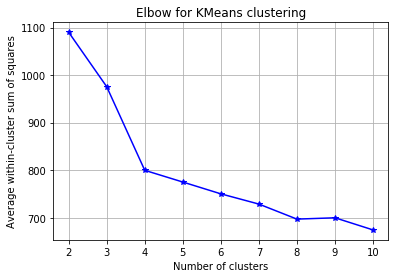

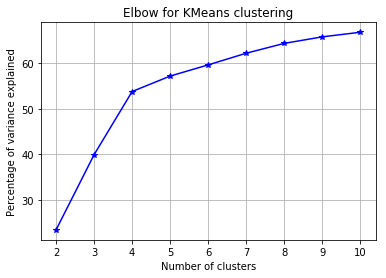

In [178]:
# Clustering for the number of establishments

# For loop reused from the ADS homework notebook created by Dr. Stanislav Sobolevsky,
# hence the inconsistence in variable naming

range_n_clusters = range(2,11)

for n_clusters in range_n_clusters:

    clusterer = KMeans(n_clusters=n_clusters, random_state=123)
    cluster_labels = clusterer.fit_predict(finalDf)
    silhouette_avg = silhouette_score(finalDf, cluster_labels)
    
    print('For n_clusters =', n_clusters,
          'The average silhouette_score is :', silhouette_avg)
    sample_silhouette_values = silhouette_samples(finalDf, cluster_labels)
    
elbow(finalDf, range_n_clusters)

#### Figure 3.1
From both of the figures above we can see, that starting from 4, the significance of the numbers of clusters becomes less important. Therefore, I will choose the number of clusters being equal to 4.

In [190]:
# Fitting K-means with 4 clusters

n = 4

km = KMeans(n_clusters=n, random_state=123)
km_res = km.fit(finalDf)

In [189]:
km_res

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

In [191]:
finalDf['kmLabels'] = km_res.labels_
finalDf.head()

,ZIPCODE,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,kmLabels
0,11436,439,2,4,4,3,2,1,6,11,...,8,5,3,2,2,2,2,2,4,2
1,11213,450,4,11,8,444,469,493,490,490,...,509,503,477,458,448,436,453,439,458,1
2,11212,10,439,433,457,490,558,563,587,566,...,582,596,584,571,570,558,572,572,560,1
3,11225,47,467,487,500,14,13,13,13,15,...,12,16,17,16,16,16,15,15,18,2
4,11218,92,10,13,15,31,35,48,37,23,...,30,20,18,18,21,19,16,16,13,2


In [230]:
kmeans = pd.DataFrame(km_res.cluster_centers_)
kmeans.columns = finalDf.columns[:-1]
kmeans.head(2)

,ZIPCODE,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,10183.632479,126.923077,153.487179,162.837607,173.025641,87.478632,123.794872,104.094017,93.982906,114.717949,...,100.316239,95.897436,88.606838,144.820513,139.726496,96.085470,82.290598,114.829060,120.162393,126.076923
1,10545.428571,304.628571,186.942857,118.657143,123.342857,511.428571,373.457143,474.285714,595.514286,460.171429,...,485.428571,533.342857,530.628571,374.685714,350.828571,494.257143,544.257143,444.657143,401.457143,378.600000


In [223]:
# Another cluster method

# Guassian Mixture:
n = 4

GM=GaussianMixture(n_components=n)
GM.fit(finalDf.iloc[:,:-1])
res_Mix=GM.predict(finalDf.iloc[:,:-1])

In [247]:
res_Mix

array([0, 3, 3, 1, 1, 1, 0, 1, 1, 1, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 0, 1, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       3, 3, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 3,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 2, 2, 3,
       3, 2, 3, 3, 0, 0, 0, 0, 0, 0, 3, 1, 0, 1, 0, 2, 3, 3])

In [274]:
finalDf.loc[:0:]

,ZIPCODE,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,kmLabels
0,11436,439,2,4,4,3,2,1,6,11,...,8,5,3,2,2,2,2,2,4,2


In [292]:
# normalizing values

normalizedDf = finalDf
normalizedDf = normalizedDf.drop('kmLabels', axis=1);

In [293]:
# My fingers bleed writing this non-pythonic solution, but no time for loops now, sorry.

normalizedDf[1994] = (normalizedDf[1994] - normalizedDf[1994].mean()) / normalizedDf[1994].std()
normalizedDf[1995] = (normalizedDf[1995] - normalizedDf[1995].mean()) / normalizedDf[1995].std()
normalizedDf[1996] = (normalizedDf[1996] - normalizedDf[1996].mean()) / normalizedDf[1996].std()
normalizedDf[1997] = (normalizedDf[1997] - normalizedDf[1997].mean()) / normalizedDf[1997].std()
normalizedDf[1998] = (normalizedDf[1998] - normalizedDf[1998].mean()) / normalizedDf[1998].std()
normalizedDf[1999] = (normalizedDf[1999] - normalizedDf[1999].mean()) / normalizedDf[1999].std()
normalizedDf[2000] = (normalizedDf[2000] - normalizedDf[2000].mean()) / normalizedDf[2000].std()
normalizedDf[2001] = (normalizedDf[2001] - normalizedDf[2001].mean()) / normalizedDf[2001].std()
normalizedDf[2002] = (normalizedDf[2002] - normalizedDf[2002].mean()) / normalizedDf[2002].std()
normalizedDf[2003] = (normalizedDf[2003] - normalizedDf[2003].mean()) / normalizedDf[2003].std()
normalizedDf[2004] = (normalizedDf[2004] - normalizedDf[2004].mean()) / normalizedDf[2004].std()
normalizedDf[2005] = (normalizedDf[2005] - normalizedDf[2005].mean()) / normalizedDf[2005].std()
normalizedDf[2006] = (normalizedDf[2006] - normalizedDf[2006].mean()) / normalizedDf[2006].std()
normalizedDf[2007] = (normalizedDf[2007] - normalizedDf[2007].mean()) / normalizedDf[2007].std()
normalizedDf[2008] = (normalizedDf[2008] - normalizedDf[2008].mean()) / normalizedDf[2008].std()
normalizedDf[2009] = (normalizedDf[2009] - normalizedDf[2009].mean()) / normalizedDf[2009].std()
normalizedDf[2010] = (normalizedDf[2010] - normalizedDf[2010].mean()) / normalizedDf[2010].std()
normalizedDf[2011] = (normalizedDf[2011] - normalizedDf[2011].mean()) / normalizedDf[2011].std()
normalizedDf[2012] = (normalizedDf[2012] - normalizedDf[2012].mean()) / normalizedDf[2012].std()
normalizedDf[2013] = (normalizedDf[2013] - normalizedDf[2013].mean()) / normalizedDf[2013].std()
normalizedDf[2014] = (normalizedDf[2014] - normalizedDf[2014].mean()) / normalizedDf[2014].std()

In [294]:
normalizedDf.head(3)

,ZIPCODE,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,11436,1.179918,-0.599034,-0.603384,-0.607043,-0.652378,-0.627804,-0.651440,-0.658323,-0.621015,...,-0.660545,-0.638964,-0.651255,-0.678079,-0.677578,-0.684992,-0.669707,-0.674207,-0.665816,-0.660958
1,11213,1.224639,-0.590668,-0.573231,-0.590069,1.305240,1.315786,1.358627,1.352974,1.367546,...,1.482017,1.520427,1.452493,1.308154,1.322107,1.392429,1.258700,1.321789,1.285678,1.355642
2,11212,-0.564189,1.228796,1.244545,1.315317,1.509436,1.686192,1.644612,1.756064,1.683059,...,1.820093,1.835069,1.845361,1.756524,1.817642,1.960692,1.800787,1.848449,1.879611,1.808711


### Time's up on this! Basically, the only thing left is the visualization. 